# Generate LVC-External GW Catalogs

## 1: Intallations + data download

Install pip packages in the current Jupyter kernel

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt --quiet

Download IAS and PyCBC posterior samples to the following data-dirs, and also the LVC GWTC-2 catalog.

In [2]:
! mkdir -p data/pycbc_search data/ias_search
! cat data_files.txt | xargs -n 3 -P 2 wget -q --show-progress

data/pycbc_search/H 100%[===================>]   1.82M  6.23MB/s    in 0.3s    
data/lvc_catalog.js 100%[===================>] 147.94K   207KB/s    in 0.7s    
data/pycbc_search/H 100%[===================>]   1.85M  6.18MB/s    in 0.3s    
data/pycbc_search/H 100%[===================>]   1.76M  6.23MB/s    in 0.3s    
data/pycbc_search/H 100%[===================>]   1.85M  6.21MB/s    in 0.3s    
data/pycbc_search/H 100%[===================>]   1.82M  6.12MB/s    in 0.3s    
data/pycbc_search/H 100%[===================>]   1.76M  6.00MB/s    in 0.3s    
data/pycbc_search/H 100%[===================>]   1.79M  6.30MB/s    in 0.3s    
data/pycbc_search/H 100%[===================>]   1.82M  6.00MB/s    in 0.3s    
data/pycbc_search/H 100%[===================>]   1.82M  6.18MB/s    in 0.3s    
data/pycbc_search/H 100%[===================>]   1.82M  6.10MB/s    in 0.3s    
data/pycbc_search/H 100%[===================>]   1.79M  6.09MB/s    in 0.3s    
data/pycbc_search/H 100%[===============

## 2: Generate External Catalogs

We can generate catalogs with the posterior samples we have just downloaded. The code for the catalog generation from posterior samples is stored in the `catalog_generators` module.

In [1]:
LVC_CATALOG = "./data/lvc_catalog.json"
IAS_CATALOG = "./data/ias_catalog.json"
PYCBC_CATALOG = "./data/pycbc_catalog.json"
CATALOGS = [LVC_CATALOG, IAS_CATALOG, PYCBC_CATALOG]

In [4]:
from catalog_generators import generate_ias_catalog
generate_ias_catalog(
    data_dir='./data/ias_search/',
    out_catalog_fname=IAS_CATALOG
)

Reading IAS Posteriors: 100%|██████████| 18/18 [00:00<00:00, 42.84it/s]


Completed catalog generation.


In [5]:
from catalog_generators import generate_pycbc_catalog
generate_pycbc_catalog(
    data_dir='./data/pycbc_search/',
    out_catalog_fname=PYCBC_CATALOG
)

Reading PyCBC Posteriors: 100%|██████████| 30/30 [00:00<00:00, 36.92it/s]


Completed catalog generation.


## 3: Display plot of Catalog Event Masses

Define functions to parse the catalog json files.

In [2]:
import pandas as pd
import json

def read_json(json_path)->dict:
    with open(json_path, 'r') as f:
        return json.load(f)

def catalog_to_dataframe(catalog_path):
    catalog_dict = read_json(catalog_path)
    events = catalog_dict['events']
    return pd.DataFrame([v for v in events.values()])

Combine the catalogs into one Pandas DataFrame.

In [3]:
catalogs_df = pd.concat([catalog_to_dataframe(c) for c in CATALOGS])
catalogs_df.columns.values

array(['GPS', 'catalog.shortName', 'chi_eff', 'chi_eff_lower',
       'chi_eff_unit', 'chi_eff_upper', 'chirp_mass', 'chirp_mass_lower',
       'chirp_mass_source', 'chirp_mass_source_lower',
       'chirp_mass_source_unit', 'chirp_mass_source_upper',
       'chirp_mass_unit', 'chirp_mass_upper', 'commonName', 'far',
       'far_lower', 'far_unit', 'far_upper', 'final_mass_source',
       'final_mass_source_lower', 'final_mass_source_unit',
       'final_mass_source_upper', 'jsonurl', 'luminosity_distance',
       'luminosity_distance_lower', 'luminosity_distance_unit',
       'luminosity_distance_upper', 'mass_1_source',
       'mass_1_source_lower', 'mass_1_source_unit', 'mass_1_source_upper',
       'mass_2_source', 'mass_2_source_lower', 'mass_2_source_unit',
       'mass_2_source_upper', 'network_matched_filter_snr',
       'network_matched_filter_snr_lower',
       'network_matched_filter_snr_unit',
       'network_matched_filter_snr_upper', 'redshift', 'redshift_lower',
       '

Plot the masses of the catalogs

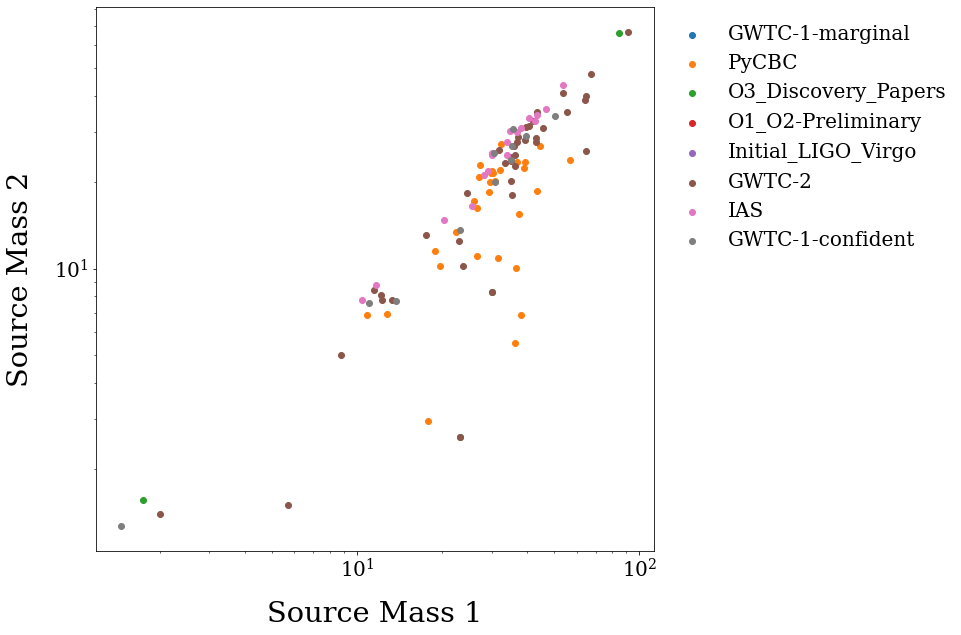

In [4]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 20
rcParams["font.family"] = "serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = False
rcParams['axes.labelsize'] = 30
rcParams['axes.titlesize'] = 30
rcParams['axes.labelpad'] = 20


def plot_masses(catalog_df):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    ax.set_xlabel("Source Mass 1", fontsize="x-large")
    ax.set_ylabel("Source Mass 2", fontsize="x-large")
    ax.set_yscale("log")
    ax.set_xscale("log")
    different_catalogs = set(list(catalog_df["catalog.shortName"]))
    for cat_name in different_catalogs:
        data = catalog_df[catalog_df["catalog.shortName"] == cat_name]
        ax.scatter(data['mass_1_source'], data['mass_2_source'], label=cat_name)
    ax.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False)

plot_masses(catalogs_df)

 14%|█▍        | 141/1000 [00:00<00:00, 1395.68it/s]

plotting m1-m2 contour


100%|██████████| 1000/1000 [00:02<00:00, 396.32it/s]
/Users/avaj0001/anaconda3/envs/phase-marginalisation-test/lib/python3.7/site-packages/ipykernel_launcher.py:112: UserWarning: No contour levels were found within the data range.
/Users/avaj0001/anaconda3/envs/phase-marginalisation-test/lib/python3.7/site-packages/ipykernel_launcher.py:112: UserWarning: The following kwargs were not used by contour: 'label'


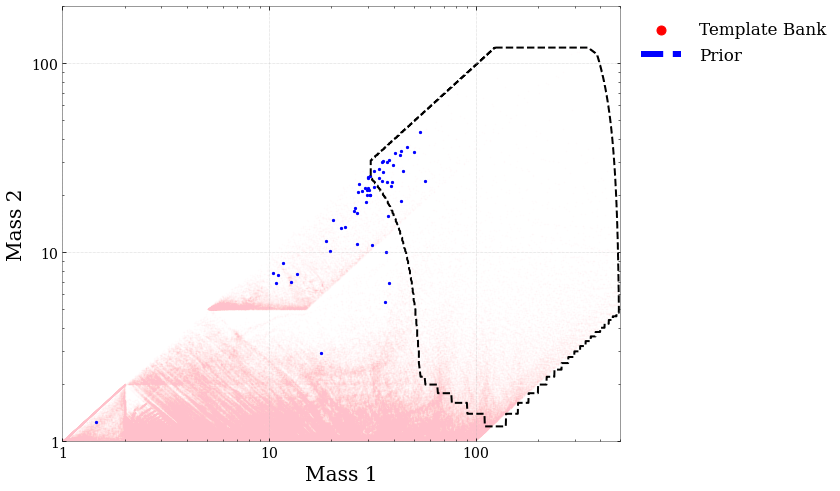

In [43]:
import numpy as np
from tqdm import tqdm
from bilby.gw import conversion
import pandas as pd

def get_m1m2_grid(m1_range, m2_range, filtering_criteria):
    """Return a meshgrid of m1, m2, z points based on filtering criteria.

    The returned meshgrid can be used to create a contour plot based on the filtering
    criteria

    :param m1_range:
    :param m2_range:
    :param filtering_criteria:
    :return:
    """
    print("plotting m1-m2 contour")
    xs = np.linspace(m1_range[0], m1_range[1], 1000)
    ys = np.linspace(m2_range[0], m2_range[1], 1000)[::-1]
    m1, m2 = np.meshgrid(xs, ys)
    z = np.zeros(shape=(len(xs), len(ys)))
    for nrx, loop_m1 in enumerate(tqdm(xs)):
        for nry, loop_m2 in enumerate(ys):
            if loop_m2 > loop_m1:
                pass  # by definition, we choose only m2 smaller than m1
            if loop_m2 < loop_m1:
                mc = conversion.component_masses_to_chirp_mass(loop_m1, loop_m2)
                M = conversion.component_masses_to_total_mass(loop_m1, loop_m2)
                q = conversion.component_masses_to_mass_ratio(loop_m1, loop_m2)
                if filtering_criteria(loop_m1, loop_m2, mc, q, M) == 1:
                    z[nry][nrx] = 1
    return m1, m2, z


def contour_condition(m1: float, m2: float, mc: float, q: float, M: float) -> int:
    """
    :param m1: mass1 val
    :param m2: mass2 val
    :param mc: chirp mass val
    :param q: mass ratio val
    :param M: total mass val
    :return: 1 if above parameters inside criteria (defined in function), otherwise 0
    """
    if (
        31 <= m1 <= 491
        and 1.32 <= m2 <= 121
        and 0.01 <= q <= 0.98
        and 8 <= mc <= 174
        and 56 <= M <= 496
    ):
        return 1
    else:
        return 0

    
    
def plot_template_bank():

    bank_csv = "/Users/avaj0001/Documents/projects/pycbc_trigger_parser/tests/test_data/template_bank.csv"
    template_bank = pd.read_csv(bank_csv, index_col=0)
    
    catalogs_df = pd.concat([catalog_to_dataframe(c) for c in CATALOGS])
    catalogs_to_keep = ['GWTC-1-confident','IAS', 'PyCBC']
    catalogs_df = catalogs_df[catalogs_df['catalog.shortName'].isin(catalogs_to_keep)]
    
    
    scatter_points = [
                # TEMPLATE BANK
                dict(
                    data=template_bank,
                    plot_kwargs=dict(
                        color="pink", s=0.5, marker=".", alpha=0.05, label="Template Bank"
                    ),
                ),
                # ALL CATALOGUE EVENTS
                dict(
                    data=pd.DataFrame(dict(mass_1=catalogs_df.mass_1_source, mass_2=catalogs_df.mass_2_source)),
                    plot_kwargs=dict(color="blue", s=5, marker="o", label="Catalogue Events"),
                ),
            ]

    prior_line = dict(
            contour_condition=contour_condition,
            plot_kwargs=dict(colors="k", linestyles="--", linewidths=2.0, label="Prior")
        )



    m1_range = [1, 500]
    m2_range = [1, 200]


    fig, ax_m1m2 = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

    axis_label_kwargs = dict(fontsize="x-large")

    # set labels
    ax_m1m2.set_xlabel("Mass 1", **axis_label_kwargs)
    ax_m1m2.set_ylabel("Mass 2", **axis_label_kwargs)

    # set scales
    ax_m1m2.set_yscale("log")
    ax_m1m2.set_xscale("log")

    # set scale limits
    ax_m1m2.set_xlim(m1_range[0], m1_range[1])
    ax_m1m2.set_ylim(m2_range[0], m2_range[1])

    # contour line
    m1_line, m2_line, m1m2_z = get_m1m2_grid(m1_range, m2_range, prior_line["contour_condition"])

    ax_m1m2.contour(m1_line, m2_line, m1m2_z, [0], **prior_line["plot_kwargs"])

    for scatter_data in scatter_points:
        ax_m1m2.scatter(scatter_data["data"].mass_1, scatter_data["data"].mass_2, **scatter_data["plot_kwargs"])

        
    bank_patch = ax_m1m2.scatter([], [], label="Template Bank", marker=".", color="r")
    prior_patch, = ax_m1m2.plot([], [], label="Prior", linestyle="--", color="b")
    handles = [bank_patch, prior_patch]
    ax_m1m2.legend(handles=handles, fontsize="large", markerscale=3, bbox_to_anchor=(1,1), loc="upper left", frameon=False)
     
    
    
plot_template_bank()
    

In [15]:
bank = "/Users/avaj0001/Documents/projects/pycbc_trigger_parser/tests/test_data/template_bank.csv"
template_bank = TemplateBank.from_csv(bank)

In [31]:
set(catalogs_df['catalog.shortName'])

{'GWTC-1-confident',
 'GWTC-1-marginal',
 'GWTC-2',
 'IAS',
 'Initial_LIGO_Virgo',
 'O1_O2-Preliminary',
 'O3_Discovery_Papers',
 'PyCBC'}

,GPS,catalog.shortName,chi_eff,chi_eff_lower,chi_eff_unit,chi_eff_upper,chirp_mass,chirp_mass_lower,chirp_mass_source,chirp_mass_source_lower,...,redshift,redshift_lower,redshift_unit,redshift_upper,reference,total_mass_source,total_mass_source_lower,total_mass_source_unit,total_mass_source_upper,version
17,1.126259e+09,GWTC-1-confident,-0.010000,-0.130000,,0.120000,NaN,NaN,28.600000,-1.500000,...,0.090000,-0.030000,,0.030000,https://doi.org/10.7935/82H3-HH23,NaN,NaN,None,NaN,3
20,1.128679e+09,GWTC-1-confident,0.050000,-0.200000,,0.310000,NaN,NaN,15.200000,-1.200000,...,0.210000,-0.090000,,0.090000,https://doi.org/10.7935/82H3-HH23,NaN,NaN,None,NaN,3
22,1.135136e+09,GWTC-1-confident,0.180000,-0.120000,,0.200000,NaN,NaN,8.900000,-0.300000,...,0.090000,-0.040000,,0.040000,https://doi.org/10.7935/82H3-HH23,NaN,NaN,None,NaN,2
24,1.167560e+09,GWTC-1-confident,-0.040000,-0.210000,,0.170000,NaN,NaN,21.400000,-1.800000,...,0.200000,-0.080000,,0.080000,https://doi.org/10.7935/82H3-HH23,NaN,NaN,None,NaN,2
27,1.180922e+09,GWTC-1-confident,0.030000,-0.070000,,0.190000,NaN,NaN,7.900000,-0.200000,...,0.070000,-0.020000,,0.020000,https://doi.org/10.7935/82H3-HH23,NaN,NaN,None,NaN,3
28,1.185390e+09,GWTC-1-confident,0.370000,-0.250000,,0.210000,NaN,NaN,35.400000,-4.800000,...,0.490000,-0.210000,,0.190000,https://doi.org/10.7935/82H3-HH23,NaN,NaN,None,NaN,1
29,1.186303e+09,GWTC-1-confident,0.080000,-0.170000,,0.170000,NaN,NaN,24.900000,-1.700000,...,0.200000,-0.070000,,0.050000,https://doi.org/10.7935/82H3-HH23,NaN,NaN,None,NaN,1
32,1.186742e+09,GWTC-1-confident,0.070000,-0.120000,,0.120000,NaN,NaN,24.100000,-1.100000,...,0.120000,-0.040000,,0.030000,https://doi.org/10.7935/82H3-HH23,NaN,NaN,None,NaN,3
35,1.187009e+09,GWTC-1-confident,0.000000,-0.010000,,0.020000,NaN,NaN,1.186000,-0.001000,...,0.010000,-0.000000,,0.000000,https://doi.org/10.7935/82H3-HH23,NaN,NaN,None,NaN,3
36,1.187058e+09,GWTC-1-confident,-0.090000,-0.210000,,0.180000,NaN,NaN,26.500000,-1.700000,...,0.210000,-0.070000,,0.070000,https://doi.org/10.7935/82H3-HH23,NaN,NaN,None,NaN,1


In [39]:
catalogs_df.to_csv('catalog.csv')